# DINOv2 2D-3D PCA 可视化

1. 从单帧 RGB + 已提取的 DINO 特征生成 2D PCA 颜色图。
2. 分别用两种 PCA 方式（方法 A / 方法 B）。
3. 将选定的 2D PCA 颜色通过相机内参和位姿投影到对应 3D 点云上进行可视化。

In [3]:
import sys
sys.path.append('/home/nebula/xxy/3D_Reconstruction')

import os
from pathlib import Path
import math

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import open3d as o3d

from oneformer3d.projection_utils import (
    SCANET_INTRINSICS,
    project_points_to_uv,
    sample_img_feat,
)

# 配置：单帧路径
IMG_PATH = Path('/home/nebula/xxy/dataset/2D/scene0000_00/color/200.jpg')
DINO_FEAT_PATH = Path('/home/nebula/xxy/3D_Reconstruction/vis_demo/200_dinov2_feat.pt')
DATA_ROOT = Path('/home/nebula/xxy/3D_Reconstruction/data/scannet200-sv')
SCENE = 'scene0000_00'
FRAME = 200
POINTS_PATH = DATA_ROOT / 'points' / f'{SCENE}_{FRAME}.bin'
POSE_PATH = DATA_ROOT / 'pose_centered' / SCENE / f'{FRAME}.npy'
OUT_DIR = Path('/home/nebula/xxy/3D_Reconstruction/vis_demo')
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATCH_SIZE = 14  # DINOv2 ViT-14 patch 大小

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def pca_color_from_nxc(x: torch.Tensor,
                       brightness: float = 1.2,
                       center: bool = True) -> torch.Tensor:
    """Concerto 风格 PCA 颜色映射：N×C 特征 -> N×3 颜色 (0~1)。"""
    x = x.float()
    x = F.normalize(x, dim=1)
    C = x.shape[1]
    q = min(6, C)
    U, S, V = torch.pca_lowrank(x, center=center, q=q, niter=5)  # V: [C,q]
    proj = x @ V  # [N, q]
    if q >= 6:
        color = proj[:, :3] * 0.6 + proj[:, 3:6] * 0.4
    elif q >= 3:
        color = proj[:, :3]
    else:
        pad = torch.zeros(x.shape[0], 3 - q, device=x.device, dtype=x.dtype)
        color = torch.cat([proj, pad], dim=1)
    min_val, _ = color.min(dim=0, keepdim=True)
    max_val, _ = color.max(dim=0, keepdim=True)
    div = torch.clamp(max_val - min_val, min=1e-6)
    color = (color - min_val) / div * brightness
    color = color.clamp(0.0, 1.0)
    return color

def imshow_rgb(img, title=None):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0.0, 1.0)
    elif isinstance(img, Image.Image):
        img = np.array(img) / 255.0
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')


## 1. 从 DINO 特征生成 2D PCA 颜色图（方法 A / 方法 B）

Original image size (W,H) = 640, 480
DINO feat shape: C=1024, H_p=35, W_p=46
Upsampled PCA (A) shape: H_up=490, W_up=644
Cropped PCA (A) shape: (480, 640, 3)


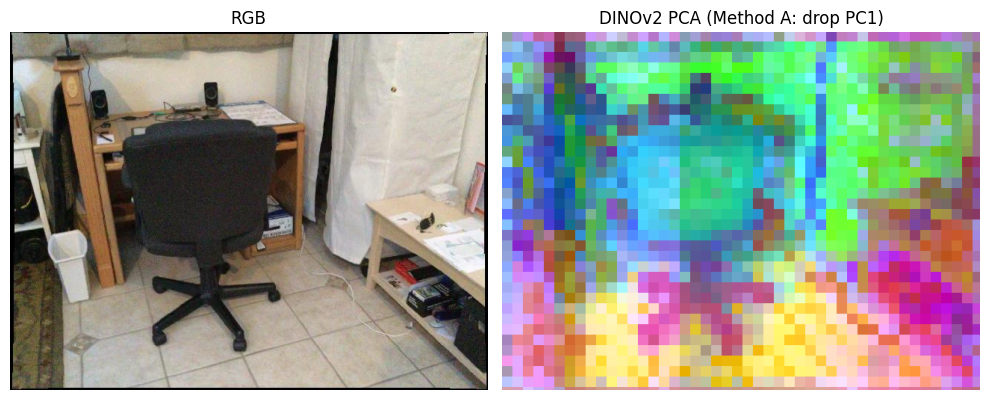

saved 2D PCA image (method A) to /home/nebula/xxy/3D_Reconstruction/vis_demo/scene0000_00_200_dino_pca_2d_methodA.png


In [4]:

# 方法 A：跳过第一个主成分（PC1），使用 PC2–PC4 映射颜色

# 读取原始 RGB
img = Image.open(IMG_PATH).convert('RGB')
W_orig, H_orig = img.size
print(f'Original image size (W,H) = {W_orig}, {H_orig}')

# 读取 DINO 特征 (C, H_p, W_p)，由 dino_rgb_vis_2d.ipynb 提前离线提取
feat = torch.load(DINO_FEAT_PATH, map_location='cpu').float()
if feat.dim() == 4:
    feat = feat[0]
C, H_p, W_p = feat.shape
print(f'DINO feat shape: C={C}, H_p={H_p}, W_p={W_p}')

# 展平为 N×C 做 PCA
x = feat.reshape(C, -1).t().float()  # (N, C)
x = F.normalize(x, dim=1)
C_feat = x.shape[1]
q = min(6, C_feat)
U, S, V = torch.pca_lowrank(x, center=True, q=q, niter=5)  # V: [C,q]
proj = x @ V  # (N, q)

if proj.size(1) >= 4:
    # 使用 PC2,3,4
    color_A = proj[:, 1:4]
elif proj.size(1) >= 3:
    color_A = proj[:, 1:4]
else:
    pad = torch.zeros(x.shape[0], 3 - proj.size(1), device=x.device, dtype=x.dtype)
    color_A = torch.cat([proj, pad], dim=1)

brightness = 1.2
min_val, _ = color_A.min(dim=0, keepdim=True)
max_val, _ = color_A.max(dim=0, keepdim=True)
div = torch.clamp(max_val - min_val, min=1e-6)
color_A = (color_A - min_val) / div * brightness
color_A = color_A.clamp(0.0, 1.0)

img_pca_patch_A = color_A.view(H_p, W_p, 3).cpu().numpy()
img_pca_patch_A = np.clip(img_pca_patch_A, 0.0, 1.0)

# 上采样回 pad 后分辨率，再裁剪到原始分辨率
img_pca_up_A = np.kron(img_pca_patch_A, np.ones((PATCH_SIZE, PATCH_SIZE, 1), dtype=img_pca_patch_A.dtype))
H_up_A, W_up_A, _ = img_pca_up_A.shape
print(f'Upsampled PCA (A) shape: H_up={H_up_A}, W_up={W_up_A}')
img_pca_crop_A = img_pca_up_A[:H_orig, :W_orig, :]
print(f'Cropped PCA (A) shape: {img_pca_crop_A.shape}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
imshow_rgb(img, title='RGB')
plt.subplot(1, 2, 2)
plt.imshow(img_pca_crop_A)
plt.title('DINOv2 PCA (Method A: drop PC1)')
plt.axis('off')
plt.tight_layout()
plt.show()

out_2d_path_A = OUT_DIR / f'{SCENE}_{FRAME}_dino_pca_2d_methodA.png'
plt.imsave(out_2d_path_A, img_pca_crop_A)
print(f'saved 2D PCA image (method A) to {out_2d_path_A}')

# 默认将方法 A 的结果赋给通用变量，供 3D 投影使用
img_pca_crop = img_pca_crop_A


Upsampled PCA (B) shape: H_up=490, W_up=644
Cropped PCA (B) shape: (480, 640, 3)


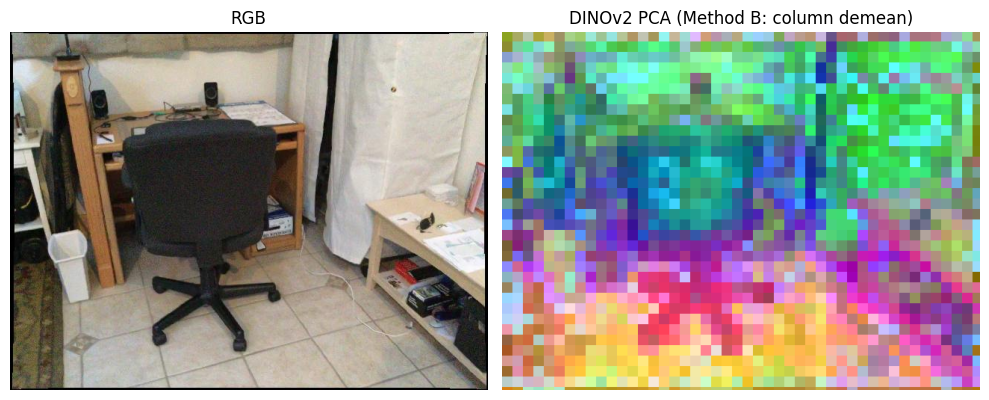

saved 2D PCA image (method B) to /home/nebula/xxy/3D_Reconstruction/vis_demo/scene0000_00_200_dino_pca_2d_methodB.png


In [5]:
# 方法 B：按列去均值后再做 Concerto 风格 PCA 映射\n

# 假设已经在上一个 cell 中加载了 img 和 feat
feat_B = feat.clone()  # (C, H_p, W_p)


# 可选：先减全局均值
feat_B = feat_B - feat_B.mean(dim=(1, 2), keepdim=True)
# 再减列均值：每一列在 H 方向的均值 (C,1,W_p)
col_mean = feat_B.mean(dim=1, keepdim=True)
feat_B = feat_B - col_mean  

# 展平为 N×C 做 PCA（使用原始 Concerto 映射）
xB = feat_B.reshape(C, -1).t().float()  # (N, C)
color_B = pca_color_from_nxc(xB)  # (N,3)
img_pca_patch_B = color_B.view(H_p, W_p, 3).cpu().numpy()
img_pca_patch_B = np.clip(img_pca_patch_B, 0.0, 1.0)

img_pca_up_B = np.kron(img_pca_patch_B, np.ones((PATCH_SIZE, PATCH_SIZE, 1), dtype=img_pca_patch_B.dtype))
H_up_B, W_up_B, _ = img_pca_up_B.shape
print(f'Upsampled PCA (B) shape: H_up={H_up_B}, W_up={W_up_B}')
img_pca_crop_B = img_pca_up_B[:H_orig, :W_orig, :]
print(f'Cropped PCA (B) shape: {img_pca_crop_B.shape}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
imshow_rgb(img, title='RGB')
plt.subplot(1, 2, 2)
plt.imshow(img_pca_crop_B)
plt.title('DINOv2 PCA (Method B: column demean)')
plt.axis('off')
plt.tight_layout()
plt.show()

out_2d_path_B = OUT_DIR / f'{SCENE}_{FRAME}_dino_pca_2d_methodB.png'
plt.imsave(out_2d_path_B, img_pca_crop_B)
print(f'saved 2D PCA image (method B) to {out_2d_path_B}')

# 如果希望 3D 投影使用方法 B 的结果，可以在运行 3D cell 前执行本 cell，使 img_pca_crop 指向方法 B 的结果
img_pca_crop = img_pca_crop_B

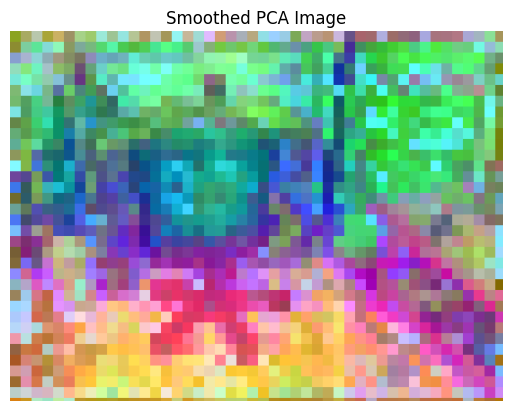

In [ ]:
import cv2
img_smoothed = cv2.GaussianBlur(img_pca_crop, (5,5), sigmaX=1.0)
#打印图片
import matplotlib.pyplot as plt
plt.imshow(img_smoothed)
plt.title('Smoothed PCA Image')
plt.axis('off')
plt.show()

## 2. 将 2D PCA 颜色投影到 3D 点云

In [6]:
# 读取 3D 点云和相机位姿
pts_arr = np.fromfile(POINTS_PATH, dtype=np.float32)
if pts_arr.size % 6 != 0:
    raise RuntimeError(f'Unexpected point file size: {POINTS_PATH}, size={pts_arr.size}')
pts = pts_arr.reshape(-1, 6)
xyz = torch.from_numpy(pts[:, :3]).to(device)
pose_cam2world = torch.from_numpy(np.load(POSE_PATH)).float().to(device)
print(f'Loaded {pts.shape[0]} points from {POINTS_PATH.name}')

# world -> cam
w2c = torch.linalg.inv(pose_cam2world)
xyz_h = torch.cat([xyz, torch.ones_like(xyz[:, :1])], dim=1)  # (N,4)
xyz_cam = (w2c @ xyz_h.t()).t()[:, :3]  # (N,3)

# 准备 2D PCA 颜色图作为 feature map: (1, 3, H, W)
H_img, W_img = img_pca_crop.shape[0], img_pca_crop.shape[1]
pca_feat = torch.from_numpy(img_pca_crop).permute(2, 0, 1).unsqueeze(0).to(device=device, dtype=torch.float32)
print(f'PCA feat map shape (for sampling): {tuple(pca_feat.shape)}')

# 将 3D 点投影到 PCA 图像坐标
uv_feat, valid = project_points_to_uv(
    xyz_cam.to(torch.float32),
    feat_hw=(H_img, W_img),
    max_depth=20.0,
    standard_intrinsics=SCANET_INTRINSICS,
    debug=True,
    debug_prefix='PCA2D',
)


# 在 PCA 图像上采样颜色
uv_feat = uv_feat.to(device=device, dtype=pca_feat.dtype)
valid = valid.to(device=device)
sampled_color = sample_img_feat(pca_feat, uv_feat, valid, align_corners=False)  # (N,3)
rgb_pca = np.zeros((pts.shape[0], 3), dtype=np.float32)
valid_np = valid.cpu().numpy().astype(bool)
rgb_pca[valid_np] = np.clip(sampled_color.cpu().numpy()[valid_np], 0.0, 1.0)
print(f'Valid projected points: {valid_np.sum()} / {valid_np.size}')

# 构建有颜色的点云并保存
pcd_pca = o3d.geometry.PointCloud()
pcd_pca.points = o3d.utility.Vector3dVector(pts[:, :3])
pcd_pca.colors = o3d.utility.Vector3dVector(rgb_pca)

out_ply = OUT_DIR / f'{SCENE}_{FRAME}_dino_pca_3d.ply'
o3d.io.write_point_cloud(str(out_ply), pcd_pca)
print(f'saved 3D PCA-colored point cloud to {out_ply}')

# 如需在 notebook 中直接查看，可取消下面一行的注释
# o3d.visualization.draw_geometries([pcd_pca])

Loaded 20000 points from scene0000_00_200.bin
PCA feat map shape (for sampling): (1, 3, 480, 640)
PCA2D projection stats: depth_ok=20000/20000, boundary_ok=20000/20000, u_range=[9.0, 635.0], v_range=[9.0, 476.0]
Valid projected points: 20000 / 20000
saved 3D PCA-colored point cloud to /home/nebula/xxy/3D_Reconstruction/vis_demo/scene0000_00_200_dino_pca_3d.ply
